In [ ]:
# First time setup
%cd /content/
!rm -rf thesis_research
!git clone https://github.com/forksup/thesis_research
%cd /content/thesis_research
!pip3 install -r requirements.txt

/content
Cloning into 'thesis_research'...
remote: Enumerating objects: 1402, done.
remote: Counting objects: 100% (1110/1110), done.
remote: Compressing objects: 100% (288/288), done.
remote: Total 1402 (delta 920), reused 997 (delta 814), pack-reused 292
Receiving objects: 100% (1402/1402), 12.41 MiB | 13.46 MiB/s, done.
Resolving deltas: 100% (1100/1100), done.
/content/thesis_research
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [ ]:
from Models.model_sources.markov_source import MarkovChain
from Models.MMC import MMC
from Models.DBN import FMC
from Models.HMC import HMC

from Models.model_sources.mtd_source import MTD
from Models.model_sources.path_encoder import PathEncoder, SequenceCutter

from run_experiments import perform_ttest
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from Datasets.Inflation_data import inflationData
from collections import defaultdict
from sklearn.model_selection import train_test_split


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
df = pd.read_csv("Datasets/data_files/inflation_data.csv")

# Filter out to the years used in MTD Paper
df['year'] = pd.to_numeric(df['year'])
df = df[(df['year'] >= 1821) & (df['year'] <= 1999)]
df = df.reset_index()


df['state_change'] = 'none'
std = df['inflation rate'].std()

df.loc[df['inflation rate'] < 0.0, 'state_change'] = "drop"
df.loc[df['inflation rate'] > 0.0, 'state_change'] = "rise"

df.loc[df['inflation rate'] <= -std, 'state_change'] = "big drop"
df.loc[df['inflation rate'] >= std, 'state_change'] = "big rise"

df.loc[df['inflation rate'] <= -2*std, 'state_change'] = "bigger drop"
df.loc[df['inflation rate'] >= 2*std, 'state_change'] = "bigger rise"

df.loc[df['inflation rate'] <= -3*std, 'state_change'] = "biggest drop"
df.loc[df['inflation rate'] >= 3*std, 'state_change'] = "biggest rise"

df = df.reset_index()

print(f"Standard Deviation = {std}")
df

Standard Deviation = 0.05524291401896159


,level_0,index,year,amount,inflation rate,state_change
0,0,21,1821,0.900,-0.030,drop
1,1,22,1822,0.930,0.040,rise
2,2,23,1823,0.830,-0.100,big drop
3,3,24,1824,0.770,-0.080,big drop
4,4,25,1825,0.790,0.020,rise
...,...,...,...,...,...,...
174,174,195,1995,12.100,0.030,rise
175,175,196,1996,12.450,0.030,rise
176,176,197,1997,12.740,0.020,rise
177,177,198,1998,12.940,0.020,rise


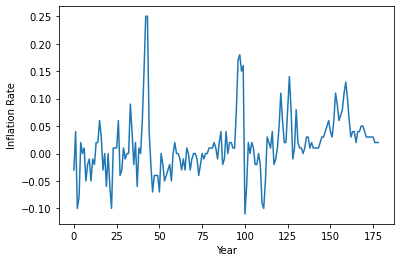

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the data on the axes
ax.plot([i for i in range(len(df))], df['inflation rate'])

# Add labels and title
ax.set(xlabel='Year', ylabel='Inflation Rate')

# Show the plot
plt.show()


In [ ]:
order = 3

sc = SequenceCutter(order)
x, y = sc.transform(df.state_change.values)

pe = PathEncoder(order)
pe.fit(x, y)

x_tr, y_tr = pe.transform(x, y)

# PD used for pretty Juptyer notebook output
display_pd = pd.DataFrame(x_tr, columns=[f"x{i+1}" for i in range(order)])
display_pd["y"] = y_tr

print("Display of X and Y training Data")
display_pd

Display of X and Y training Data


,x1,x2,x3,y
0,4,6,0,0
1,6,0,0,6
2,0,0,6,5
3,0,6,5,6
4,6,5,6,4
...,...,...,...,...
171,6,6,6,6
172,6,6,6,6
173,6,6,6,6
174,6,6,6,6


In [ ]:
# Now let's run the experiments

# We will run the experiment randomly splitting the data into training 
# and testing data 100 times, due to the low dataset size we must take the
# average of many trials 

amount_to_average = 500
 
methods = [MMC, FMC, HMC, MTD] 
types = [m.__name__ for m in methods]

experiment_results = defaultdict(list)

combined_arrays = np.concatenate((x_tr.flatten(),y_tr), axis=0)
state_count = len(np.unique(combined_arrays))

for _ in range(amount_to_average):
    X_train, X_test, y_train, y_test = train_test_split(x_tr, y_tr)

    args_training = {"X_train": X_train, "y_train": y_train}
    args_testing =   {"X_test": X_test, "y_test": y_test}

    for m in methods:
        model = m(state_count, order=order)
        MarkovChain.calculate_time(model.train, args_training)
        testing = MarkovChain.calculate_time(model.test, args_testing)
        experiment_results[m.__name__].append(testing[0])


In [ ]:
picked_lags = []
utility = []
for key, item in enumerate(experiment_results['MMC']):
  picked_lags.extend(item[1])
  utility.append(item[2])
  experiment_results['MMC'][key] = item[0]


In [ ]:
sum(utility)/len(utility)

0.11668801386615733

In [ ]:
#utility_dont_combine = utility
utility_do_combine = utility

In [ ]:
import scipy.stats as stats
stats.ttest_rel(utility_dont_combine, utility_do_combine)


Ttest_relResult(statistic=-0.15020803160103352, pvalue=0.8806611844086544)

In [ ]:
rows = [i for i in range(order)]

percent = {}
for r in rows:
  percent[r] = picked_lags.count(r) / len(picked_lags)

percent_df = pd.DataFrame(percent.items(), columns=["Lag", "%"])
percent_df.style.hide_index()



Lag,%
0,0.640591
1,0.229909
2,0.129500


In [ ]:
len(picked_lags)

22000

In [ ]:
# Now we can calulate the averge performance of each model across all 1000 trials

def average(lst):
    return sum(lst) / len(lst)

percentage_dict = {}
for key, values in experiment_results.items():
    result = round(average(values) * 100,2)
    percentage_dict[key] = f"{result}%"

testing_results = pd.DataFrame(percentage_dict.items(), columns=["Model", "Training Accuracy"])

testing_results = testing_results.sort_values("Training Accuracy", ascending=False)

## Results of the experiment 

In [ ]:
testing_results.style.hide_index()


Model,Training Accuracy
MMC,50.88%
MTD,48.19%
FMC,47.64%
HMC,37.63%


## Perform an independent ttest on all trials 

In [ ]:
"# Now let's do the T_TEST"
t_test_df = perform_ttest(methods, experiment_results)
pd.set_option('display.float_format','{:.3f}'.format)
t_test_df

,MMC-FMC,MMC-HMC,MMC-MTD
0,0.000,0.000,0.000


## Final experiment results 

In [ ]:

params = {
          "Dataset": "Inflation",
          "Order":order, 
          "Dataset Size": len(x_tr),
          "State Size": len(df.state_change.unique()),
          "Std Deviation": std,
          "# of Trials": amount_to_average
          }

experiment_params = pd.DataFrame(params.items(), columns=["Param", "Value"])

print("Experiment Description")
display(experiment_params.style.hide_index())
print("")

print("Accuracy")
display(testing_results.style.hide_index())
print("")
print("T_Test")
display(t_test_df.style.hide_index())
print("")
print("Lag Position %")
display(percent_df.style.hide_index())

Experiment Description


Param,Value
Dataset,Inflation
Order,3
Dataset Size,176
State Size,7
Std Deviation,0.055243
# of Trials,500



Accuracy


Model,Training Accuracy
MMC,50.87%
MTD,48.24%
FMC,47.96%
HMC,38.1%



T_Test


MMC-FMC,MMC-HMC,MMC-MTD
0.000000,0.000000,0.000000



Lag Position %


Lag,%
0,0.640136
1,0.231136
2,0.128727


## Here are the results in LATEX:

In [ ]:

params = {
          "Dataset": "Inflation",
          "Order":order, 
          "Dataset Size": len(x_tr),
          "State Size": len(df.state_change.unique()),
          "Std Deviation": std,
          "# of Trials": amount_to_average
          }

experiment_params = pd.DataFrame(params.items(), columns=["Param", "Value"])

print("Experiment Description")
display(experiment_params.style.hide_index().to_latex())
print("")

print("Accuracy")
display(testing_results.style.hide_index().to_latex())
print("")
print("T_Test")
display(t_test_df.style.hide_index().to_latex())
print("")
print("Lag Position %")
display(percent_df.style.hide_index().to_latex())

Experiment Description


'\\begin{tabular}{ll}\n{Param} & {Value} \\\\\nDataset & Inflation \\\\\nOrder & 3 \\\\\nDataset Size & 176 \\\\\nState Size & 7 \\\\\nStd Deviation & 0.055243 \\\\\n# of Trials & 500 \\\\\n\\end{tabular}\n'


Accuracy


'\\begin{tabular}{ll}\n{Model} & {Training Accuracy} \\\\\nMMC & 50.87% \\\\\nMTD & 48.24% \\\\\nFMC & 47.96% \\\\\nHMC & 38.1% \\\\\n\\end{tabular}\n'


T_Test


'\\begin{tabular}{rrr}\n{MMC-FMC} & {MMC-HMC} & {MMC-MTD} \\\\\n0.000000 & 0.000000 & 0.000000 \\\\\n\\end{tabular}\n'


Lag Position %


'\\begin{tabular}{rr}\n{Lag} & {%} \\\\\n0 & 0.640136 \\\\\n1 & 0.231136 \\\\\n2 & 0.128727 \\\\\n\\end{tabular}\n'

## Experiment Description 

[Data Source](https://https://www.minneapolisfed.org/about-us/monetary-policy/inflation-calculator/consumer-price-index-1913-)

In this experiment we are taking the inflationary data from the US CPI from 1821 to 1999 as is used in "[The Mixture Transition Distribution Model for High-Order Markov Chains and Non-Gaussian Time Series](https://projecteuclid.org/journals/statistical-science/volume-17/issue-3/The-Mixture-Transition-Distribution-Model-for-High-Order-Markov-Chains/10.1214/ss/1042727943.full)". This consits of a total of 179 observations. In order to transform this data into a state representation we divide the dataset in accordance to how it lies within the distribution of it's standard deviation. A "drop" state lies within 0 and -std, big drop within -std and -2std and bigger drop within -2std and -3std. And vice versa for the ranges between 0 and 2std. This results in a total state space of 6. 

Now since this dataset is a mere 179 observations, we will need to run 1000 trials splitting up the data into training and testing randomly each iteration in an effort to have an acceptable sample size.  Once complete, we calculate the average performance of each model across all 1000 trials.

To Summarize:
*   Order: 3 
*   Dataset Size: 176
*   Sate Size: 8
*   Standard Deviation of CPI Data = 0.05524291401896159
*   Average of 500 trials


It is important to note that MMC is using misalignments and is using a greedy SGO identification technique. 


